In [1]:
# !git clone https://github.com/facebookresearch/sam2.git

# !python3 -m venv .venv
# !source .venv/bin/activate
# !pip install --upgrade pip
# !pip install torch torchvision

# %cd /Users/sambra/Documents/GitHub

# import torch
# print("MPS available:", torch.backends.mps.is_available())

# !pip install -e ./sam2
# !pip install -e "./sam2[notebooks]"

In [10]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import numpy as np

device = "mps" if torch.backends.mps.is_available() else "cpu"
ckpt = "/Users/sambra/Documents/GitHub/sam2_clone/checkpoints/sam2.1_hiera_large.pt"
cfg  = "/configs/sam2.1/sam2.1_hiera_l.yaml"

# turn off the CUDA-only post-processing:
sam = build_sam2(cfg, ckpt, device=device, apply_postprocessing=False) # must be false otherwise cuda throws a paddy
predictor = SAM2ImagePredictor(sam)

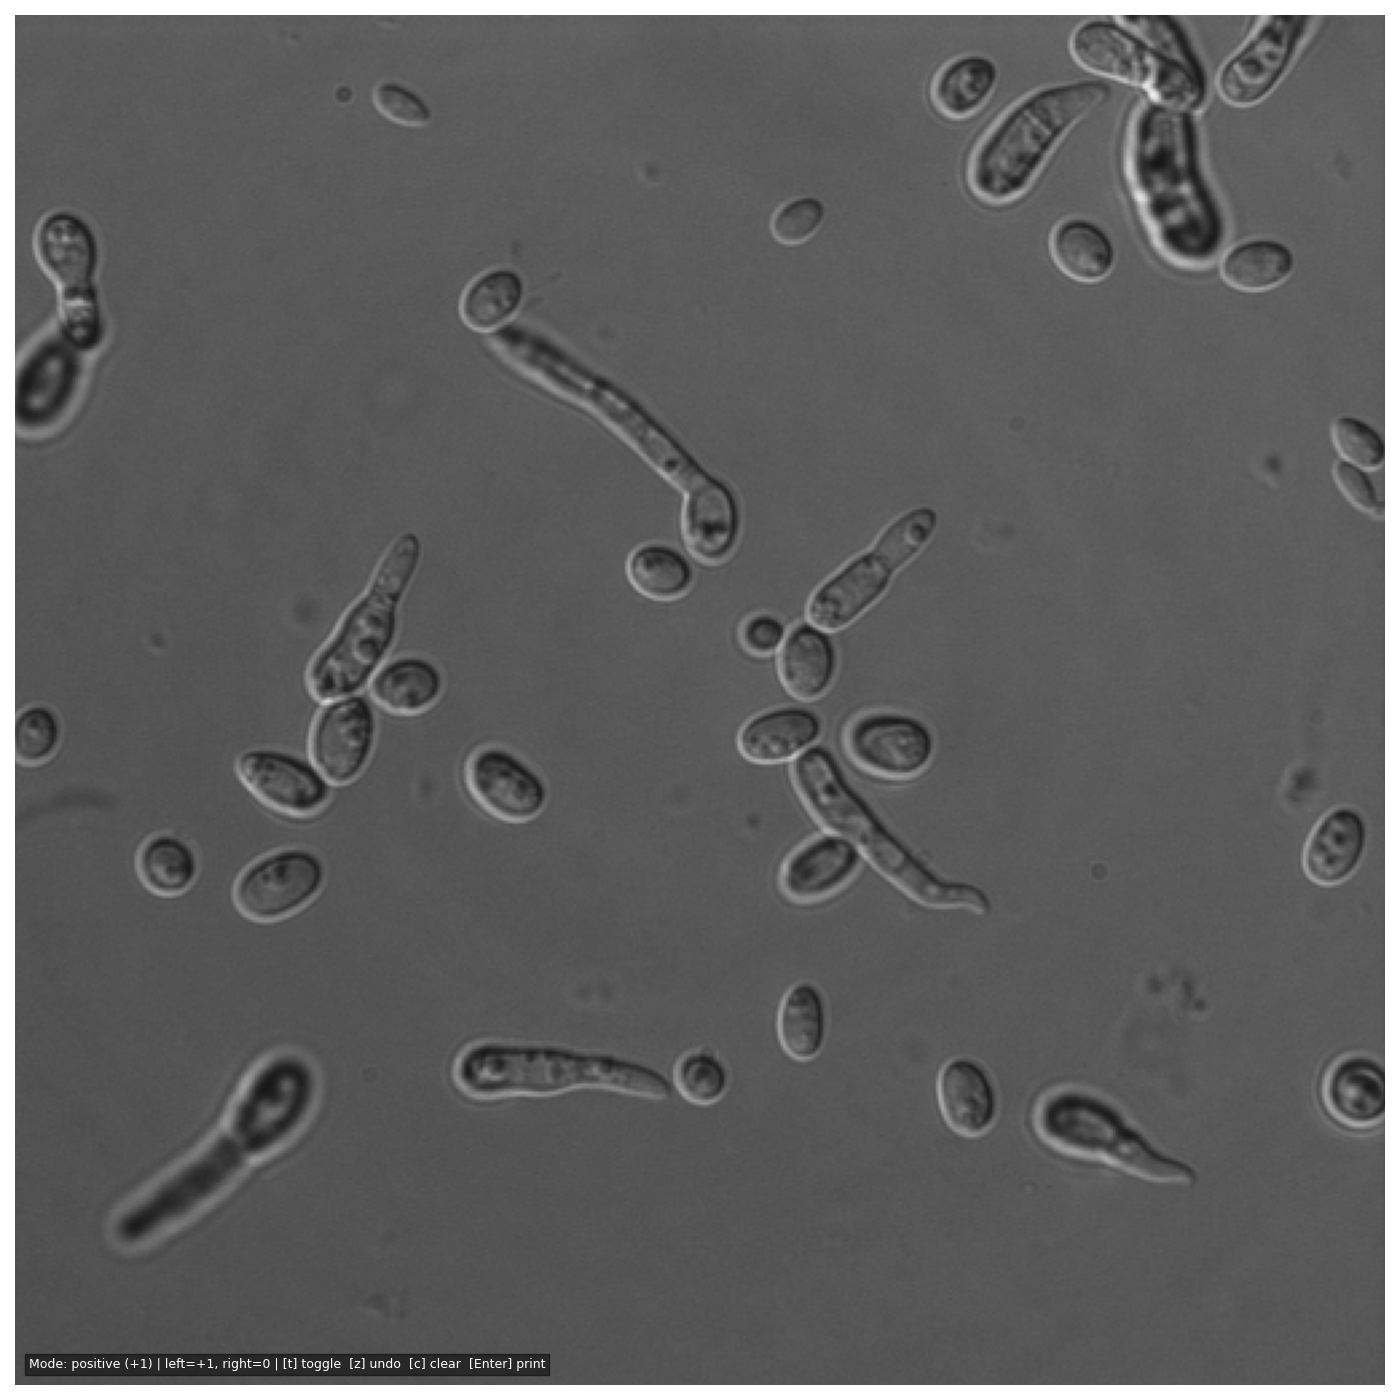

In [11]:
%matplotlib widget

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class PointSelector:
    """Click on the image to add points; keeps coords and labels for SAM2."""
    def __init__(self, ax, image_array):
        self.ax = ax
        self.image = image_array
        self.h, self.w = image_array.shape[:2]
        self.points = []   # list of (x, y)
        self.labels = []   # 1=positive, 0=negative
        self.mode = 1      # current mode for left-clicks: 1=positive, 0=negative

        # scatter artists for live visualization
        self.sc_pos = ax.scatter([], [], c='lime', marker='*', s=200,
                                 edgecolors='white', linewidths=1.25, zorder=3)
        self.sc_neg = ax.scatter([], [], c='red', marker='*', s=200,
                                 edgecolors='white', linewidths=1.25, zorder=3)

        # instructions
        self.help = ax.text(
            0.01, 0.01, self._mode_text(),
            color='white', fontsize=9,
            bbox=dict(facecolor='black', alpha=0.5, pad=3),
            transform=ax.transAxes, ha='left', va='bottom', zorder=4
        )

        self.cid_click = ax.figure.canvas.mpl_connect('button_press_event', self._on_click)
        self.cid_key   = ax.figure.canvas.mpl_connect('key_press_event',   self._on_key)
        self._redraw()

    def _mode_text(self):
        mode = "positive (+1)" if self.mode == 1 else "negative (0)"
        return f"Mode: {mode} | left=+1, right=0 | [t] toggle  [z] undo  [c] clear  [Enter] print"

    def _on_click(self, event):
        if event.inaxes != self.ax or event.xdata is None or event.ydata is None:
            return
        x = int(np.clip(round(event.xdata), 0, self.w - 1))
        y = int(np.clip(round(event.ydata), 0, self.h - 1))
        # left=1, right=3; fallback to current mode
        label = 1 if event.button == 1 else (0 if event.button == 3 else self.mode)
        self.points.append((x, y))
        self.labels.append(label)
        self._redraw()
        self._print_arrays()

    def _on_key(self, event):
        if event.key in ('t', 'T'):
            self.mode = 1 - self.mode
            self.help.set_text(self._mode_text())
            self.ax.figure.canvas.draw_idle()
        elif event.key in ('z', 'backspace'):
            if self.points:
                self.points.pop(); self.labels.pop()
                self._redraw(); self._print_arrays()
        elif event.key in ('c', 'C'):
            self.points.clear(); self.labels.clear()
            self._redraw(); self._print_arrays()
        elif event.key in ('enter', 'return'):
            self._print_arrays()

    def _redraw(self):
        pos = np.array([p for p, l in zip(self.points, self.labels) if l == 1], dtype=int)
        neg = np.array([p for p, l in zip(self.points, self.labels) if l == 0], dtype=int)
        self.sc_pos.set_offsets(pos if pos.size else np.empty((0, 2)))
        self.sc_neg.set_offsets(neg if neg.size else np.empty((0, 2)))
        self.ax.figure.canvas.draw_idle()

    @property
    def input_point(self):
        return np.array(self.points, dtype=int) if self.points else np.empty((0, 2), dtype=int)

    @property
    def input_label(self):
        return np.array(self.labels, dtype=int) if self.labels else np.empty((0,), dtype=int)

    def _print_arrays(self):
        pts, labs = self.input_point, self.input_label
        print("input_point = np.array([")
        for x, y in pts:
            print(f"    [{x}, {y}],")
        print("])")
        print("input_label = np.array([", end="")
        print(", ".join(map(str, labs.tolist())), end="")
        print("])")

# --- Usage ---
img_path = "/Users/sambra/Documents/GitHub/sporecounting/Images/Original/ICI Dkmt1 1-0044 IMAGEJ.TIF"  # change this to your file
img = np.array(Image.open(img_path).convert("RGB"))

# --- Make it bigger but still show the whole image ---
h, w = img.shape[:2]
target_width_px = 1400                         # tweak as you like
target_height_px = int(target_width_px * h / w)

fig, ax = plt.subplots(figsize=(target_width_px/100, target_height_px/100), dpi=100)
# Expand the ipympl canvas (widget size)
fig.canvas.layout.width  = f'{target_width_px}px'
fig.canvas.layout.height = f'{target_height_px}px'

ax.imshow(img)
ax.set_axis_off()

# Ensure the full image is in view (no cropping) and correct orientation
ax.set_xlim(0, w - 1)
ax.set_ylim(h - 1, 0)                          # y goes down in image coords
ax.set_aspect('equal', adjustable='box')       # preserve aspect ratio
plt.tight_layout()

pts = PointSelector(ax, img)

In [12]:
points = pts.input_point 

def to_N12(points, dtype=int):
    """(N,2) -> (N,1,2) numpy array."""
    pts = np.asarray(points, dtype=dtype)
    if pts.ndim != 2 or pts.shape[1] != 2:
        raise ValueError("Expected shape (N,2)")
    return pts[:, None, :]



/Users/sambra/miniforge3/envs/sam2_env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/xz/wnmpfwfd79bbx_lqntg_fwgc0000gp/T/ipykernel_70204/3946672681.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", masks_best.shape[0])


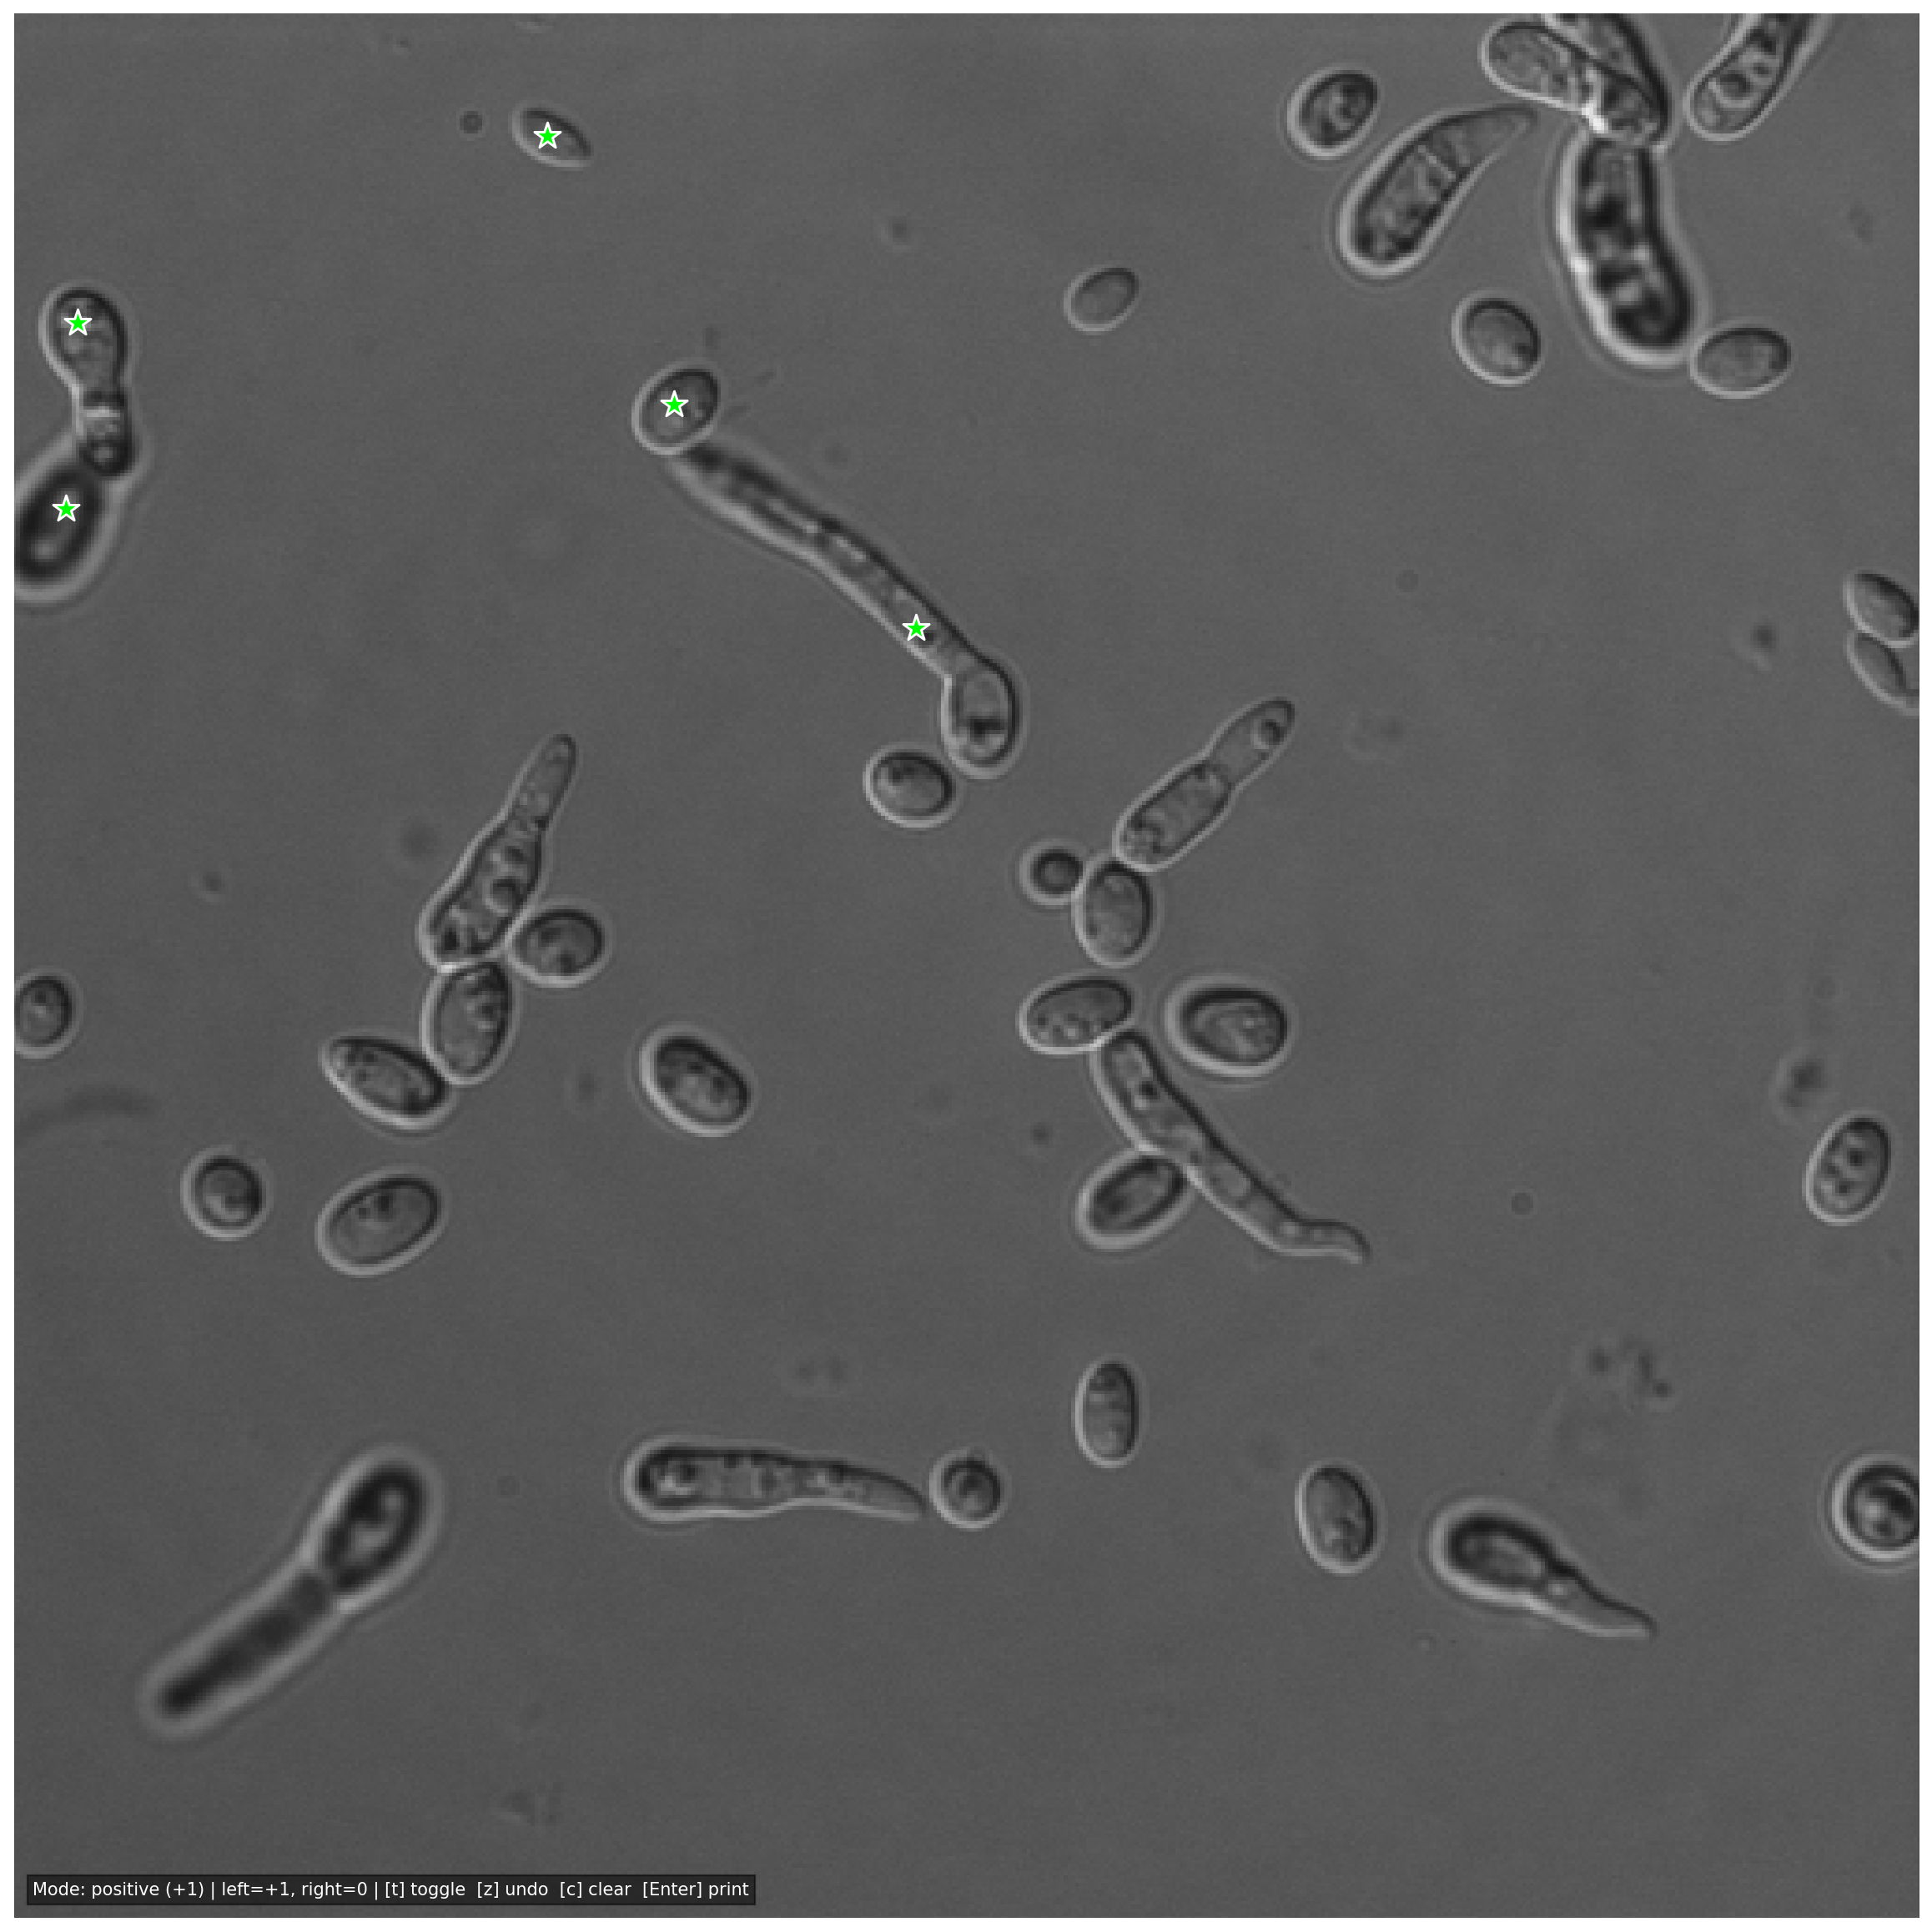

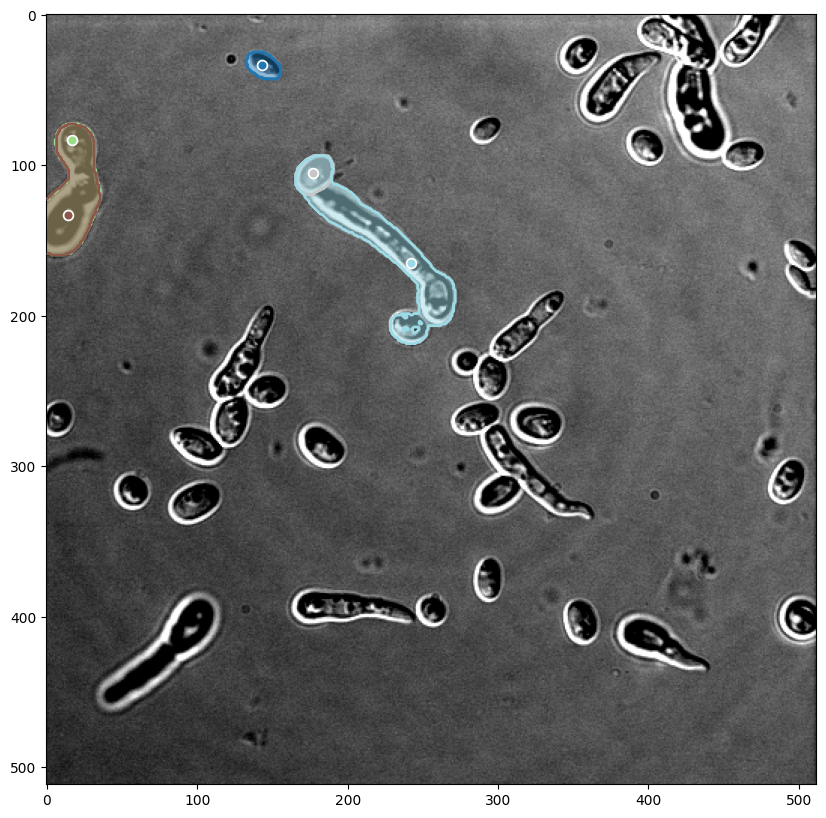

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import torch

# ---------------- inputs ----------------
input_point = to_N12(points)
input_label = np.array([[1] for _ in range(len(input_point))], dtype=np.int32)

# ---------------- image ----------------
def increase_contrast_pil(img_in, factor=5):
    img_pil = img_in if isinstance(img_in, Image.Image) else Image.fromarray(img_in)
    return np.array(ImageEnhance.Contrast(img_pil.convert("RGB")).enhance(factor), dtype=np.uint8)

image_pil = Image.open(img_path).convert("RGB")
image_np  = increase_contrast_pil(image_pil, factor=5)   # HWC uint8

# ---------------- predict: one best mask per point ----------------
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image_batch([image_np])

# batch where this single image has many point-prompts
pts_batch    = [input_point]   # list length = num images (1)
labels_batch = [input_label]

masks_batch, scores_batch, _ = predictor.predict_batch(
    pts_batch, labels_batch, box_batch=None, multimask_output=False
)
# shapes for our single image: masks_i=(N,M,H,W), scores_i=(N,M)
masks_i, scores_i = masks_batch[0], scores_batch[0]
best_idx   = scores_i.argmax(-1)                         # (N,)
row_idx    = np.arange(scores_i.shape[0])
masks_best = masks_i[row_idx, best_idx]                  # (N,H,W)
scores_best= scores_i[row_idx, best_idx]                 # (N,)

# ---------------- visualize all best masks + points on one image ----------------
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_np)
ax.axis("off")

cmap = plt.cm.get_cmap("tab20", masks_best.shape[0])

for i, (m, s) in enumerate(zip(masks_best, scores_best)):
    color_rgb  = np.array(cmap(i)[:3])
    color_rgba = np.r_[color_rgb, 0.5]

    m2d = np.asarray(m).squeeze()
    if m2d.ndim == 3:                      # rare: reduce any leftover channel
        m2d = m2d[..., 0]
    m2d = (m2d > 0).astype(float)

    ax.imshow(m2d[..., None] * color_rgba[None, None, :], zorder=2)
    ax.contour(m2d, levels=[0.5], colors=[tuple(color_rgb)], linewidths=2, zorder=3)

    p = input_point[i, 0]                  # (x, y)
    ax.scatter(p[0], p[1], color=tuple(color_rgb), marker='o', s=50,
               edgecolor='white', linewidth=1.25, zorder=5)
plt.axis('on')
plt.show()


/var/folders/xz/wnmpfwfd79bbx_lqntg_fwgc0000gp/T/ipykernel_70204/2317195577.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", masks_best.shape[0])


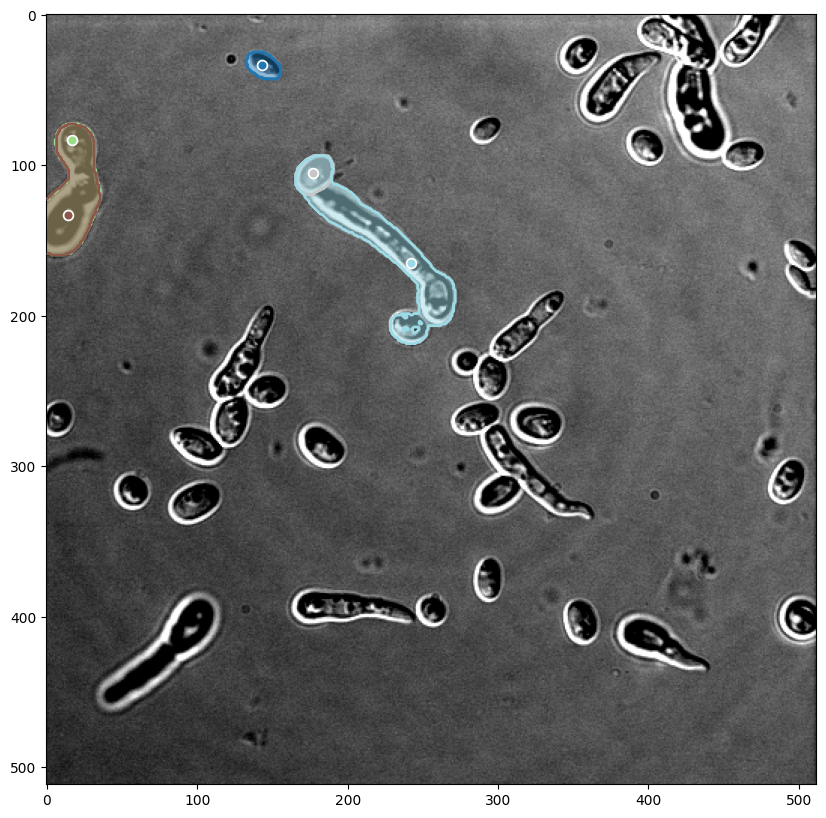

In [14]:
# ---------------- visualize all best masks + points on one image ----------------
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_np)
ax.axis("off")

cmap = plt.cm.get_cmap("tab20", masks_best.shape[0])

for i, (m, s) in enumerate(zip(masks_best, scores_best)):
    color_rgb  = np.array(cmap(i)[:3])
    color_rgba = np.r_[color_rgb, 0.5]

    m2d = np.asarray(m).squeeze()
    if m2d.ndim == 3:                      # rare: reduce any leftover channel
        m2d = m2d[..., 0]
    m2d = (m2d > 0).astype(float)

    ax.imshow(m2d[..., None] * color_rgba[None, None, :], zorder=2)
    ax.contour(m2d, levels=[0.5], colors=[tuple(color_rgb)], linewidths=2, zorder=3)

    p = input_point[i, 0]                  # (x, y)
    ax.scatter(p[0], p[1], color=tuple(color_rgb), marker='o', s=50,
               edgecolor='white', linewidth=1.25, zorder=5)
plt.axis('on')
plt.show()

In [15]:
import numpy as np

def save_masks_bitpacked(path, masks):
    """
    masks: (N,H,W) array; bool or 0/1.
    Writes a single .npz with bit-packed masks + original shape.
    """
    m = (np.asarray(masks) > 0)
    N, H, W = m.shape
    packed = np.packbits(m, axis=-1)              # (N,H,ceil(W/8))
    np.savez_compressed(
        path,
        packed=packed,
        shape=np.array([N, H, W], dtype=np.int32),
    )

def load_masks_bitpacked(path):
    z = np.load(path, allow_pickle=False)
    packed = z["packed"]
    N, H, W = map(int, z["shape"])
    m = np.unpackbits(packed, axis=-1)[:, :, :W]   # (N,H,W) uint8 0/1
    return np.ascontiguousarray(m.astype(np.float32))                         # (N,H,W) bool

# Save
save_masks_bitpacked("masks_best.npz", masks_best)

# Load later
masks_best_loaded = load_masks_bitpacked("masks_best.npz")



In [16]:
masks_best_loaded

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

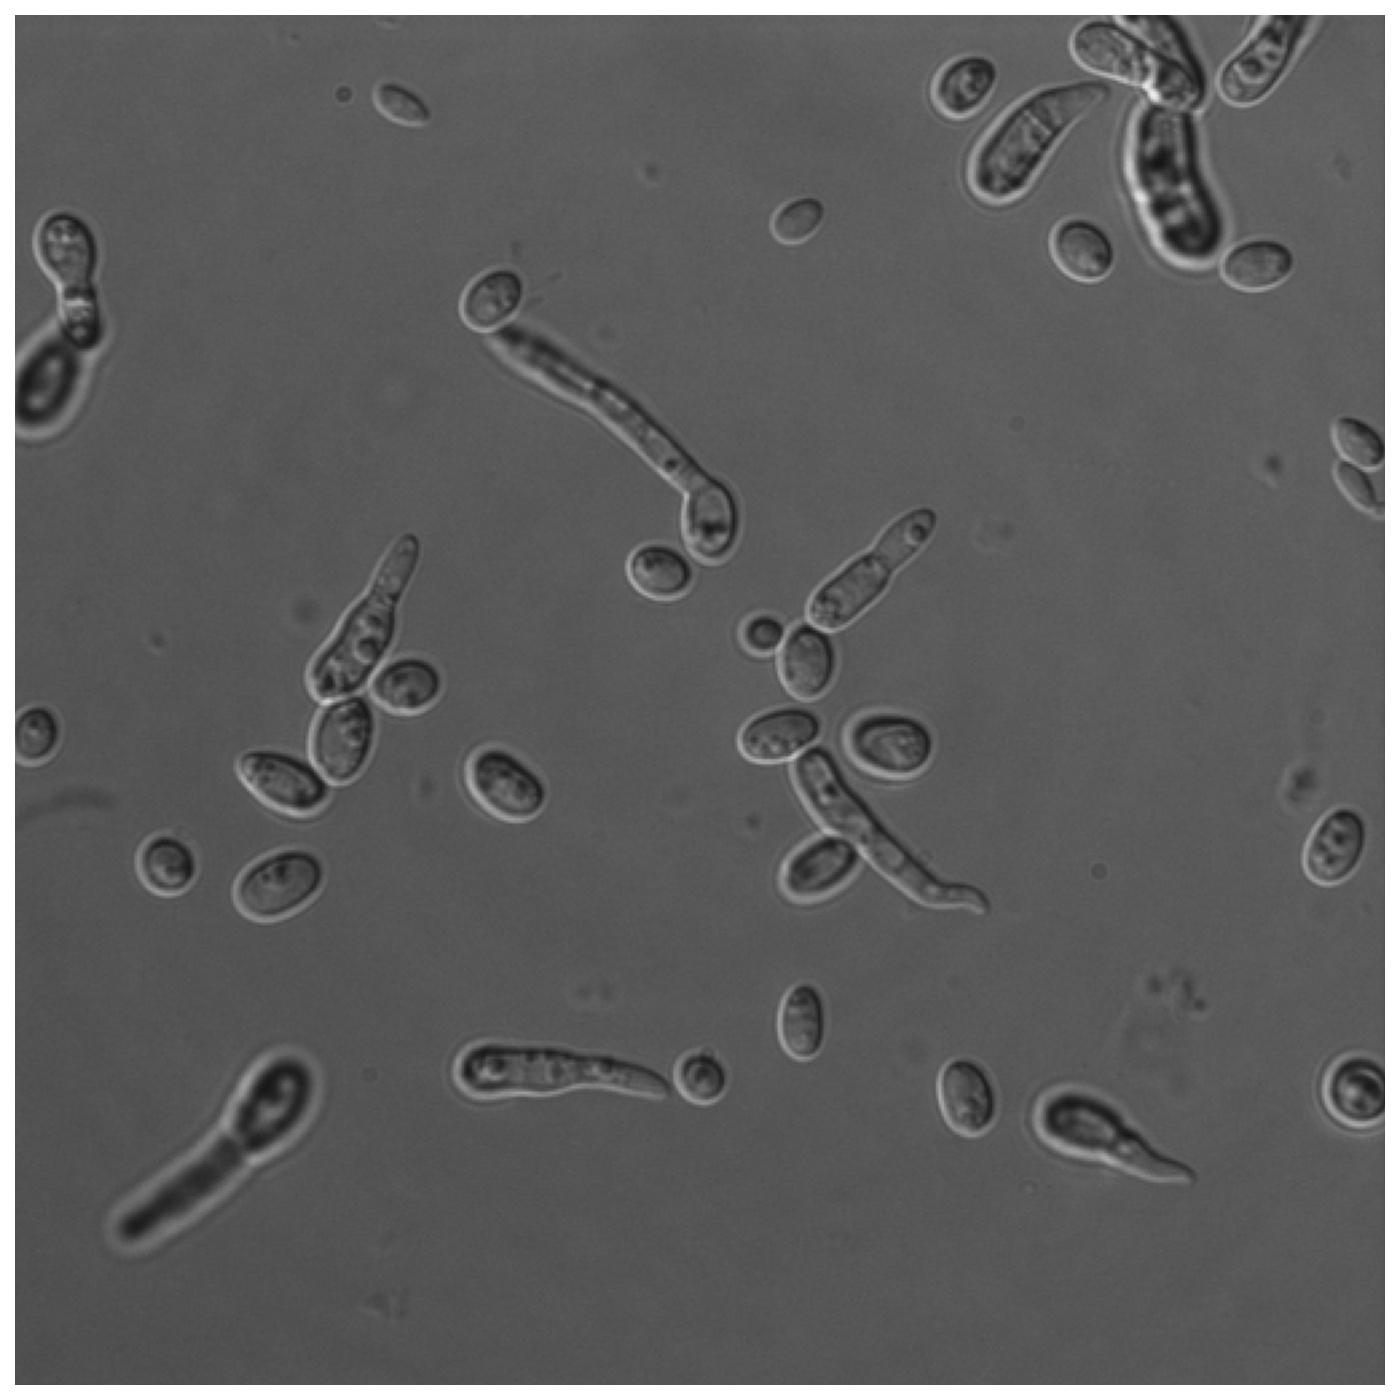

In [17]:
%matplotlib widget

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from matplotlib.patches import Rectangle

class ROISelector:
    """Draw boxes on an image and get coords as (x1,y1,x2,y2)."""
    def __init__(self, ax, image_array):
        self.ax = ax
        self.image = image_array
        self.h, self.w = image_array.shape[:2]
        self.bbox = None
        self.bboxes = []

        self.selector = RectangleSelector(
            ax, self._on_select,
            interactive=True,
            button=[1],
            minspanx=3, minspany=3,
            spancoords='pixels'
        )

    def _on_select(self, eclick, erelease):
        if None in (eclick.xdata, eclick.ydata, erelease.xdata, erelease.ydata):
            return
        x1, y1 = int(round(eclick.xdata)),  int(round(eclick.ydata))
        x2, y2 = int(round(erelease.xdata)), int(round(erelease.ydata))

        x1, x2 = sorted((max(0, x1), min(self.w - 1, x2)))
        y1, y2 = sorted((max(0, y1), min(self.h - 1, y2)))

        self.bbox = (x1, y1, x2, y2)
        self.bboxes.append(self.bbox)

        self.ax.add_patch(Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1,
                                    fill=False, linewidth=2))
        self.ax.figure.canvas.draw_idle()
        self._print_input_boxes()

    @property
    def input_boxes(self):
        return np.array(self.bboxes, dtype=int)

    def _print_input_boxes(self):
        arr = self.input_boxes
        print("input_boxes = np.array([")
        for x1, y1, x2, y2 in arr:
            print(f"    [{x1}, {y1}, {x2}, {y2}],")
        print("])")

# --- Usage ---
img_path = "/Users/sambra/Documents/GitHub/sporecounting/Images/Original/ICI Dkmt1 1-0044 IMAGEJ.TIF"
img = np.array(Image.open(img_path).convert("RGB"))

# --- Make it bigger but still show the whole image ---
h, w = img.shape[:2]
target_width_px = 1400                         # tweak as you like
target_height_px = int(target_width_px * h / w)

fig, ax = plt.subplots(figsize=(target_width_px/100, target_height_px/100), dpi=100)
# Expand the ipympl canvas (widget size)
fig.canvas.layout.width  = f'{target_width_px}px'
fig.canvas.layout.height = f'{target_height_px}px'

ax.imshow(img)
ax.set_axis_off()

# Ensure the full image is in view (no cropping) and correct orientation
ax.set_xlim(0, w - 1)
ax.set_ylim(h - 1, 0)                          # y goes down in image coords
ax.set_aspect('equal', adjustable='box')       # preserve aspect ratio
plt.tight_layout()

roi = ROISelector(ax, img)


In [18]:
roi.bboxes

[(29, 376, 120, 469),
 (158, 375, 246, 408),
 (244, 381, 270, 410),
 (283, 360, 304, 393),
 (342, 384, 369, 421),
 (378, 393, 443, 441)]

/var/folders/xz/wnmpfwfd79bbx_lqntg_fwgc0000gp/T/ipykernel_70204/788735113.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", masks_best.shape[0])


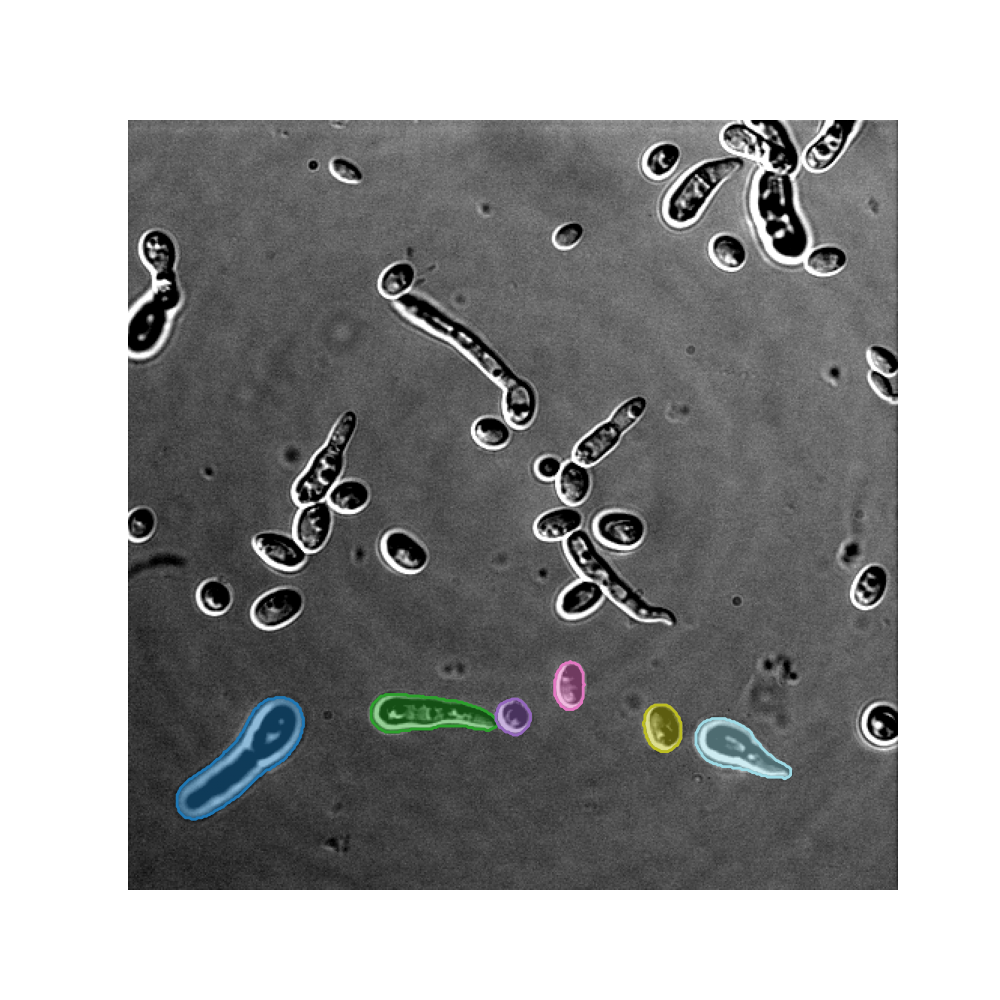

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import torch

# --- load image as HWC uint8 ---
image_pil = Image.open("/Users/sambra/Documents/GitHub/sporecounting/Images/Original/ICI Dkmt1 1-0044 IMAGEJ.TIF").convert("RGB")

# --- 4. Contrast Stretching ---
def increase_contrast_pil(img_in, factor=5):
    """
    Accepts PIL.Image or HWC NumPy; returns HWC uint8 NumPy (RGB).
    """
    if isinstance(img_in, np.ndarray):
        img_pil = Image.fromarray(img_in)
    else:
        img_pil = img_in
    img_pil = img_pil.convert("RGB")  # ensure 3-channel
    enhanced = ImageEnhance.Contrast(img_pil).enhance(factor)
    out = np.array(enhanced).astype(np.uint8)  # HWC uint8
    return out

image_pil = increase_contrast_pil(image_pil)

image_np  = np.array(image_pil)

# --- your boxes (remove degenerate ones) ---
input_boxes = np.array(roi.bboxes, dtype=np.float32)

w = input_boxes[:, 2] - input_boxes[:, 0]
h = input_boxes[:, 3] - input_boxes[:, 1]
valid_mask = (w > 0) & (h > 0)
boxes = input_boxes[valid_mask]

# --- run SAM2 with boxes ---
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(image_np)

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=boxes,
    multimask_output=True,   # returns multiple proposals per box
)
# masks: (B, M, H, W), scores: (B, M)

# --- pick best proposal per box ---
best_idx    = scores.argmax(-1)                          # (B,)
row_idx     = np.arange(scores.shape[0])
masks_best  = masks[row_idx, best_idx]                   # (B, H, W)  -> 2D masks
scores_best = scores[row_idx, best_idx]                  # (B,)

# --- visualize all best masks on ONE image ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_np)
ax.axis("off")

# nice distinct colors
cmap = plt.cm.get_cmap("tab20", masks_best.shape[0])

for i, (m, b, s) in enumerate(zip(masks_best, boxes, scores_best)):
    # overlay semi-transparent colored mask
    color_rgb = np.array(cmap(i)[:3])
    color_rgba = np.concatenate([color_rgb, [0.5]])  # alpha
    m_float = m.astype(float)
    ax.imshow(m_float[..., None] * color_rgba[None, None, :], zorder=2)

    # optional: draw a thin contour using matplotlib (no cv2 dependency)
    ax.contour(m_float, levels=[0.5], colors=[tuple(color_rgb)], linewidths=2, zorder=3)

plt.show()


NameError: name 'image_np' is not defined

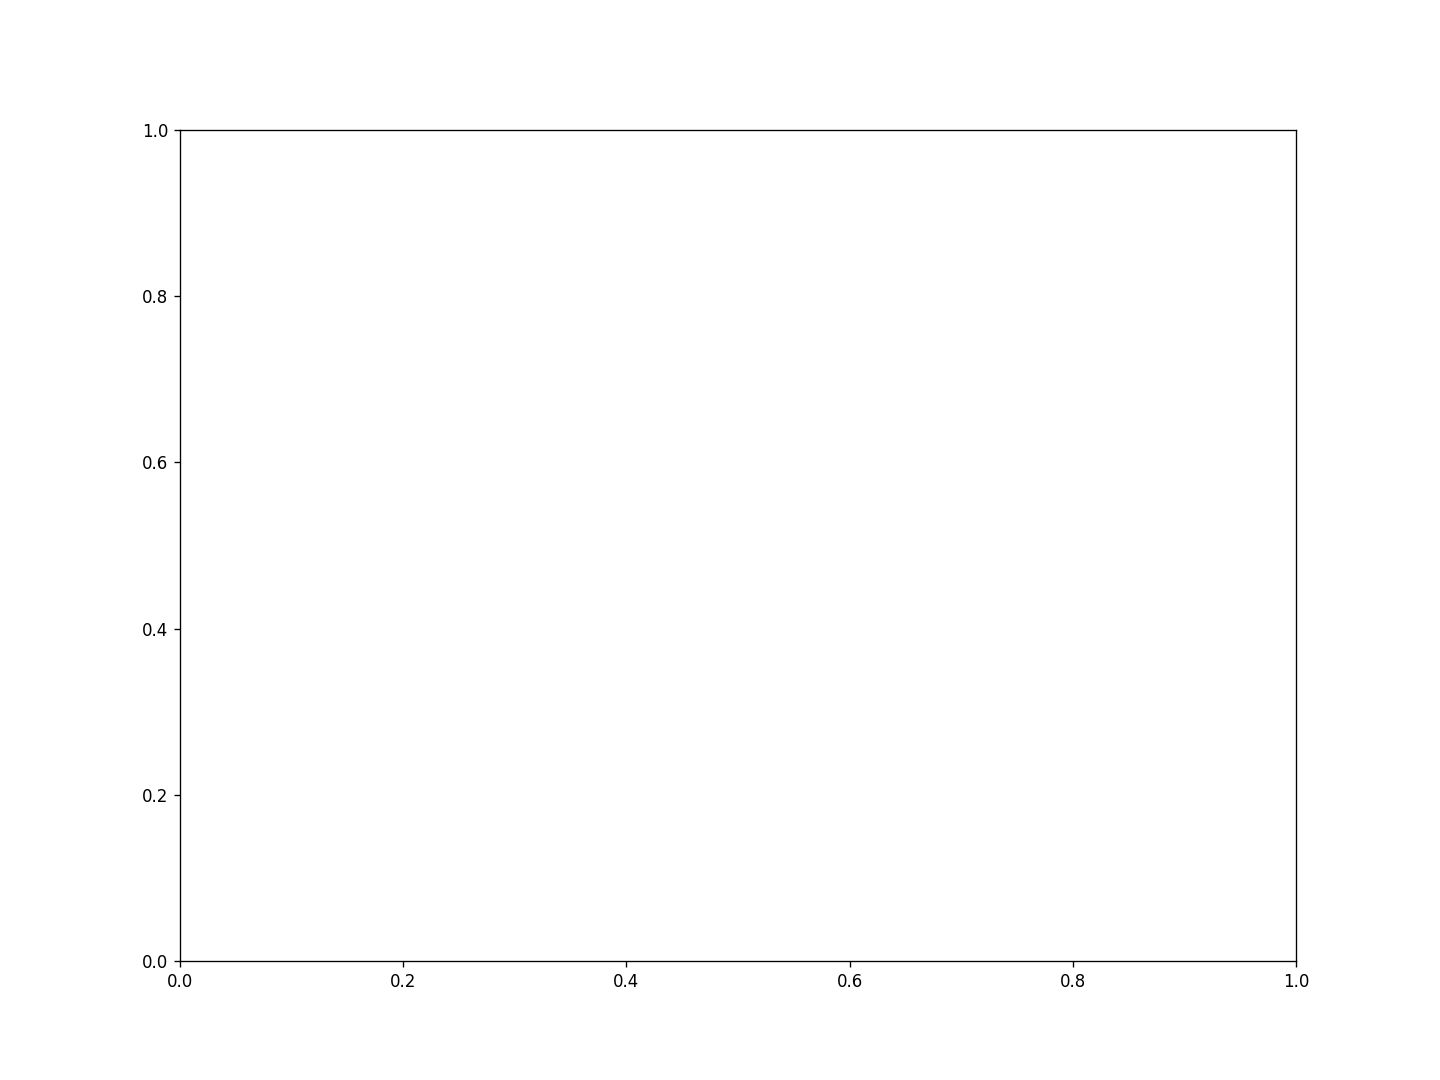

In [ ]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image

class MaskClickToggler:
    """
    Click on a displayed image to toggle masks on/off.
    - Left click: toggle the topmost mask under the cursor
    - 'a' : activate all
    - 'c' : clear all
    - 'z'/'u' : undo last toggle
    - 'enter' : print active indices
    """
    def __init__(self, ax, image, masks, scores=None, points=None, alpha=0.45):
        """
        image : HxWx3 uint8 or PIL.Image
        masks : (N,H,W) bool/0-1/uint8
        scores: optional (N,) for ordering when multiple masks overlap
        points: optional (N,1,2) or (N,2) to plot point markers
        """
        self.ax = ax
        self.image = np.array(image) if isinstance(image, Image.Image) else image
        m = np.asarray(masks)
        if m.ndim == 2:  # single mask -> (1,H,W)
            m = m[None, ...]
        if m.ndim == 3 and m.dtype != np.uint8:
            m = (m > 0).astype(np.uint8)
        self.masks = m  # (N,H,W) uint8 {0,1}
        self.N, self.H, self.W = self.masks.shape

        self.scores = None if scores is None else np.asarray(scores).reshape(-1)
        if self.scores is not None and len(self.scores) == self.N:
            # draw higher-score masks "on top"
            self.draw_order = np.argsort(self.scores)  # low->high (we'll pick last match)
        else:
            self.draw_order = np.arange(self.N)

        # state
        self.active = np.ones(self.N, dtype=bool)
        self.history = []  # stack of (idx, prev_state)

        # base image
        self.im_artist = self.ax.imshow(self.image)
        self.ax.set_axis_off()

        # colors per mask
        cmap = plt.cm.get_cmap("tab20", max(self.N, 1))
        self.colors = np.array([cmap(i % cmap.N)[:3] for i in range(self.N)])
        self.alpha = float(alpha)

        # overlay artists, one per mask
        self.overlay_artists = []
        for i in range(self.N):
            overlay = self._rgba_for_mask(self.masks[i], self.colors[i], visible=True)
            artist = self.ax.imshow(overlay, zorder=2)
            self.overlay_artists.append(artist)

        # optional: draw points
        if points is not None:
            pts = np.asarray(points)
            if pts.ndim == 3 and pts.shape[1] == 1:
                pts = pts[:, 0, :]
            if pts.ndim == 2 and pts.shape[1] == 2:
                for i, p in enumerate(pts):
                    self.ax.scatter(p[0], p[1], color=self.colors[i%len(self.colors)],
                                    marker='o', s=40, edgecolor='white', linewidth=1.0, zorder=3)

        # help text
        self.text = self.ax.text(
            0.01, 0.01,
            "Click: toggle mask | a: all on | c: clear | z/u: undo | Enter: print",
            color='white', fontsize=9,
            bbox=dict(facecolor='black', alpha=0.5, pad=3),
            transform=self.ax.transAxes, ha='left', va='bottom', zorder=4
        )

        # connect events
        self.cid_click = self.ax.figure.canvas.mpl_connect('button_press_event', self._on_click)
        self.cid_key   = self.ax.figure.canvas.mpl_connect('key_press_event',    self._on_key)

        self.ax.figure.canvas.draw_idle()

    def _rgba_for_mask(self, mask2d, color_rgb, visible=True):
        m = (np.asarray(mask2d) > 0).astype(np.float32)
        rgba = np.zeros((self.H, self.W, 4), dtype=np.float32)
        if visible:
            rgba[..., :3] = color_rgb
            rgba[..., 3]  = m * self.alpha
        return rgba

    def _on_click(self, event):
        if event.inaxes != self.ax or event.xdata is None or event.ydata is None:
            return
        x = int(np.clip(round(event.xdata), 0, self.W - 1))
        y = int(np.clip(round(event.ydata), 0, self.H - 1))

        # find all active masks covering (y,x)
        hits = [i for i in self.draw_order if self.active[i] and self.masks[i, y, x] > 0]
        if not hits:
            return
        idx = hits[-1]  # choose the "topmost" (highest score / last drawn)
        # toggle
        prev = self.active[idx]
        self.active[idx] = ~self.active[idx]
        self.history.append((idx, prev))
        # update artist visibility by replacing RGBA
        self.overlay_artists[idx].set_data(
            self._rgba_for_mask(self.masks[idx], self.colors[idx], visible=self.active[idx])
        )
        self.ax.figure.canvas.draw_idle()

    def _on_key(self, event):
        k = (event.key or "").lower()
        if k in ('z', 'u'):  # undo
            if self.history:
                idx, prev = self.history.pop()
                self.active[idx] = prev
                self.overlay_artists[idx].set_data(
                    self._rgba_for_mask(self.masks[idx], self.colors[idx], visible=self.active[idx])
                )
                self.ax.figure.canvas.draw_idle()
        elif k == 'c':  # clear all
            for i in range(self.N):
                if self.active[i]:
                    self.history.append((i, True))
                    self.active[i] = False
                    self.overlay_artists[i].set_data(
                        self._rgba_for_mask(self.masks[i], self.colors[i], visible=False)
                    )
            self.ax.figure.canvas.draw_idle()
        elif k == 'a':  # activate all
            for i in range(self.N):
                if not self.active[i]:
                    self.history.append((i, False))
                    self.active[i] = True
                    self.overlay_artists[i].set_data(
                        self._rgba_for_mask(self.masks[i], self.colors[i], visible=True)
                    )
            self.ax.figure.canvas.draw_idle()
        elif k in ('enter', 'return'):
            idxs = np.where(self.active)[0].tolist()
            print(f"Active masks: {idxs} (count={len(idxs)})")

    # ----- public helpers -----
    def get_active_masks(self, as_uint8=True):
        """Return stacked masks for currently active set."""
        idxs = np.where(self.active)[0]
        out = self.masks[idxs]
        if as_uint8 and out.dtype != np.uint8:
            out = out.astype(np.uint8)
        return out

    def get_active_indices(self):
        return np.where(self.active)[0]

# ----------------- USAGE -----------------

#Example:
fig, ax = plt.subplots(figsize=(12, 9), dpi=120)
ax.imshow(image_np); ax.axis("off")
editor = MaskClickToggler(ax, image_np, masks_best, scores=scores_best, points=input_point)
# After editing:
pruned_masks = editor.get_active_masks()         # (K,H,W)
kept_indices = editor.get_active_indices().tolist()


In [21]:
pruned_masks

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

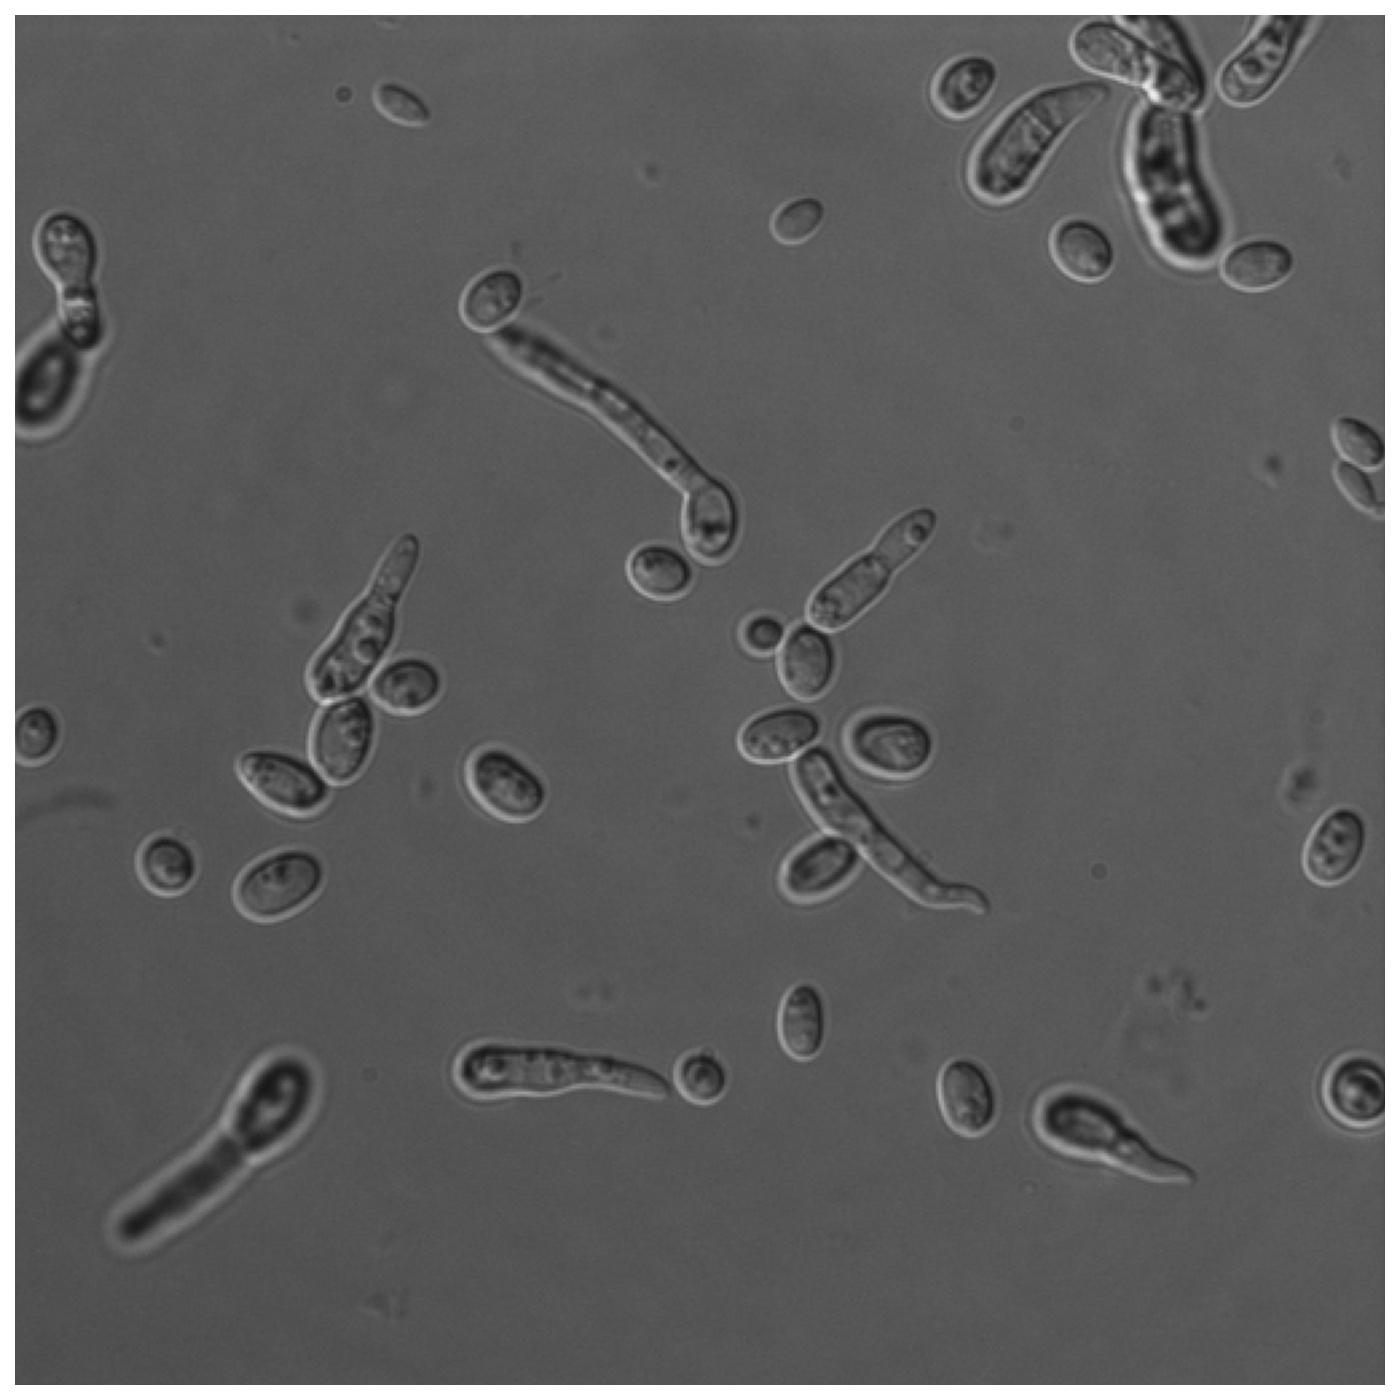

In [2]:
%matplotlib widget

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

class FreehandClosedShapeDrawer:
    """
    Draw freehand closed shapes on an image by left-clicking and dragging.

    Key behaviors:
      - On release, the path is ALWAYS closed (first point == last point) if it has >= 3 points.
      - While drawing, if the cursor is within `snap_radius` pixels of the start point,
        it auto-previews closure and snaps on release.
      - Right-click to undo the last shape.

    Attributes:
      shapes: list of np.ndarray, each of shape (N,2) int with shapes[i][0] == shapes[i][-1]
    """
    def __init__(self, ax, image_array, linewidth=2, snap_radius=8, print_on_add=True, show_snap_hint=True):
        self.ax = ax
        self.image = image_array
        self.h, self.w = image_array.shape[:2]

        # Settings
        self.linewidth = linewidth
        self.snap_radius = float(snap_radius)
        self.print_on_add = print_on_add
        self.show_snap_hint = show_snap_hint

        # State
        self._drawing = False
        self._curr_pts = []
        self._curr_line: Line2D | None = None
        self._snap_active = False
        self._snap_hint: Circle | None = None

        self.shapes = []   # list[np.ndarray], each closed polygon (first==last)
        self._lines = []   # artists for drawn shapes

        # Connect events
        canvas = self.ax.figure.canvas
        self._cid_press   = canvas.mpl_connect('button_press_event',   self._on_press)
        self._cid_move    = canvas.mpl_connect('motion_notify_event',  self._on_move)
        self._cid_release = canvas.mpl_connect('button_release_event', self._on_release)

    def _clip_to_image(self, x, y):
        xi = int(round(np.clip(x, 0, self.w - 1)))
        yi = int(round(np.clip(y, 0, self.h - 1)))
        return xi, yi

    def _ensure_snap_hint(self, x0, y0):
        if not self.show_snap_hint:
            return
        if self._snap_hint is None:
            self._snap_hint = Circle((x0, y0), radius=self.snap_radius,
                                     fill=False, linewidth=1.5, alpha=0.6, linestyle='--')
            self.ax.add_patch(self._snap_hint)
        else:
            self._snap_hint.center = (x0, y0)
            self._snap_hint.set_radius(self.snap_radius)

    def _set_snap_hint_visible(self, visible):
        if self._snap_hint is not None:
            self._snap_hint.set_visible(visible)

    def _on_press(self, event):
        if event.inaxes != self.ax:
            return

        # Right-click -> undo last shape
        if event.button == 3:
            if self.shapes:
                self.shapes.pop()
                line = self._lines.pop()
                line.remove()
                # Remove snap hint if present (kept for current drawing only)
                self.ax.figure.canvas.draw_idle()
                self._print_shapes()
            return

        # Only left button draws
        if event.button != 1:
            return
        if event.xdata is None or event.ydata is None:
            return

        self._drawing = True
        self._curr_pts = []
        x, y = self._clip_to_image(event.xdata, event.ydata)
        self._curr_pts.append([x, y])

        # Start line
        self._curr_line = Line2D([x], [y], linewidth=self.linewidth, solid_capstyle='round')
        self.ax.add_line(self._curr_line)

        # Prepare snap hint ring around start
        self._ensure_snap_hint(x, y)
        self._set_snap_hint_visible(True)
        self._snap_active = False

        self.ax.figure.canvas.draw_idle()

    def _on_move(self, event):
        if not self._drawing or event.inaxes != self.ax:
            return
        if event.xdata is None or event.ydata is None:
            return

        x, y = self._clip_to_image(event.xdata, event.ydata)

        # Avoid duplicate points
        if not self._curr_pts or (x, y) != tuple(self._curr_pts[-1]):
            self._curr_pts.append([x, y])

        xs, ys = zip(*self._curr_pts)

        # Snap detection (needs at least 3 vertices to close meaningfully)
        if len(self._curr_pts) >= 3:
            x0, y0 = self._curr_pts[0]
            dx, dy = x - x0, y - y0
            self._snap_active = (dx*dx + dy*dy) ** 0.5 <= self.snap_radius
        else:
            self._snap_active = False

        # Preview closure when snapping: append start to end in the preview
        if self._snap_active and len(self._curr_pts) >= 3:
            xs = list(xs) + [self._curr_pts[0][0]]
            ys = list(ys) + [self._curr_pts[0][1]]

        self._curr_line.set_data(xs, ys)
        self.ax.figure.canvas.draw_idle()

    def _close_polygon(self, pts):
        """Return a closed polygon (first == last)."""
        if len(pts) < 3:
            return None  # ignore too-short paths
        # Remove any duplicated final point (if already equal to start)
        if pts[-1][0] == pts[0][0] and pts[-1][1] == pts[0][1]:
            closed = np.array(pts, dtype=int)
        else:
            closed = np.vstack([np.array(pts, dtype=int), np.array(pts[0], dtype=int)])
        return closed

    def _on_release(self, event):
        if not self._drawing:
            return

        self._drawing = False
        self._set_snap_hint_visible(False)

        # If snapping was active, ensure last point equals start
        if self._snap_active and len(self._curr_pts) >= 3:
            # Replace last vertex with the start to avoid a tiny tail
            self._curr_pts[-1] = self._curr_pts[0][:]

        closed = self._close_polygon(self._curr_pts)
        if closed is None:
            # Not enough points; remove temp line and exit
            if self._curr_line is not None:
                self._curr_line.remove()
                self._curr_line = None
            self.ax.figure.canvas.draw_idle()
            return

        # Update the on-figure line to display the closed loop
        xs, ys = closed[:, 0], closed[:, 1]
        self._curr_line.set_data(xs, ys)

        # Commit
        self.shapes.append(closed)
        self._lines.append(self._curr_line)

        # Reset temp state
        self._curr_line = None
        self._curr_pts = []
        self._snap_active = False

        self.ax.figure.canvas.draw_idle()
        if self.print_on_add:
            self._print_shapes()

    def _print_shapes(self):
        print("shapes = [")
        for arr in self.shapes:
            print("    np.array([")
            for x, y in arr:
                print(f"        [{x}, {y}],")
            print("    ], dtype=int),")
        print("]")

# --- Usage ---
img_path = "/Users/sambra/Documents/GitHub/sporecounting/Images/Original/ICI Dkmt1 1-0044 IMAGEJ.TIF"
img = np.array(Image.open(img_path).convert("RGB"))

# --- Make it bigger but still show the whole image ---
h, w = img.shape[:2]
target_width_px = 1400
target_height_px = int(target_width_px * h / w)

fig, ax = plt.subplots(figsize=(target_width_px/100, target_height_px/100), dpi=100)
fig.canvas.layout.width  = f'{target_width_px}px'
fig.canvas.layout.height = f'{target_height_px}px'

ax.imshow(img)
ax.set_axis_off()
ax.set_xlim(0, w - 1)
ax.set_ylim(h - 1, 0)          # y goes down in image coords
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()

drawer = FreehandClosedShapeDrawer(ax, img, linewidth=2, snap_radius=8, print_on_add=True)

# Access closed shapes (each first point == last point):
# drawer.shapes


In [3]:
drawer.shapes

[array([[181,  93],
        [177,  96],
        [174,  97],
        [171,  99],
        [169, 100],
        [168, 101],
        [166, 102],
        [165, 103],
        [164, 104],
        [163, 105],
        [163, 106],
        [163, 107],
        [163, 108],
        [163, 109],
        [163, 110],
        [163, 111],
        [163, 112],
        [164, 112],
        [164, 113],
        [165, 114],
        [165, 115],
        [166, 115],
        [168, 117],
        [168, 118],
        [169, 118],
        [169, 119],
        [170, 119],
        [173, 119],
        [174, 119],
        [175, 119],
        [175, 118],
        [177, 118],
        [178, 117],
        [179, 117],
        [180, 116],
        [181, 116],
        [183, 115],
        [184, 115],
        [186, 114],
        [187, 114],
        [187, 113],
        [189, 112],
        [189, 111],
        [190, 111],
        [190, 108],
        [190, 107],
        [190, 106],
        [190, 105],
        [190, 104],
        [190, 103],


In [ ]:
import numpy as np
from skimage.draw import polygon

def shapes_to_masks(shapes, image_shape):
    """
    Convert list of closed polygons into stacked binary masks.

    Parameters
    ----------
    shapes : list of np.ndarray
        Each entry is an (N,2) array of (x,y) vertices, closed (first == last).
    image_shape : tuple
        (H, W) of the image.

    Returns
    -------
    masks : np.ndarray
        Boolean/int array of shape (len(shapes), H, W),
        where each [i] is a binary mask for shapes[i].
    """
    H, W = image_shape
    masks = np.zeros((len(shapes), H, W), dtype=np.uint8)

    for i, poly in enumerate(shapes):
        if poly.shape[0] < 3:
            continue  # not a valid polygon
        xs, ys = poly[:, 0], poly[:, 1]
        rr, cc = polygon(ys, xs, (H, W))   # note: polygon expects (row, col) = (y, x)
        masks[i, rr, cc] = 1

    return masks

# Suppose you already drew shapes:
shapes = drawer.shapes   # list of (N,2) arrays
h, w = img.shape[:2]

masks = shapes_to_masks(shapes, (h, w))



(11, 512, 512)


In [12]:
import numpy as np

def save_masks_bitpacked(path, masks):
    """
    masks: (N,H,W) array; bool or 0/1.
    Writes a single .npz with bit-packed masks + original shape.
    """
    m = (np.asarray(masks) > 0)
    N, H, W = m.shape
    packed = np.packbits(m, axis=-1)              # (N,H,ceil(W/8))
    np.savez_compressed(
        path,
        packed=packed,
        shape=np.array([N, H, W], dtype=np.int32),
    )

def load_masks_bitpacked(path):
    z = np.load(path, allow_pickle=False)
    packed = z["packed"]
    N, H, W = map(int, z["shape"])
    m = np.unpackbits(packed, axis=-1)[:, :, :W]   # (N,H,W) uint8 0/1
    return np.ascontiguousarray(m.astype(np.float32))                         # (N,H,W) bool

# Save
save_masks_bitpacked("masks_drawn.npz", masks)

# Load later
masks_best_loaded = load_masks_bitpacked("masks_drawn.npz")